In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Uncomment the follwing line to enabled devlib debugging statements
#logging.getLogger('ssh').setLevel(logging.INFO)

In [2]:
%pylab inline

import json
import os
import time

import devlib
from env import TestEnv
from wlgen import RTA

import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    "platform"    : "linux",
    "board"       : "juno",
    "modules"     : ['bl',"cpufreq"],
    "host"        : "192.168.0.10",
    "username"    : "root",
    "password"    : "",
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    },
    "tftp"        : {
                        "folder"    : "/var/lib/tftpboot",
                        "kernel"    : "kern.bin",
                        "dtb"       : "dtb.bin"
    },
}

# Setup the required Test Environment supports
my_tests_conf = {
    "modules" : ['bl', 'cpufreq'],
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    "ftrace"  : {
         "events" : [
             "sched:*",
             "cpu_frequency",
             "cpu_capacity"
         ],
         "buffsize" : 10240
    }
}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

06:31:29  INFO    :         Target - Using base path: /home/derkling/Code/schedtest
06:31:30  INFO    : %14s - Loading custom (inline) target configuration
06:31:30  INFO    :         Target - Connecing linux target with: {'username': 'root', 'host': '192.168.0.10', 'password': ''}
06:31:34  INFO    :         Target - Initializing target workdir [/root/devlib-target]
06:31:37  INFO    : Target topology: [[0, 3, 4, 5], [1, 2]]
06:31:40  INFO    :         FTrace - Enabled events:
06:31:40  INFO    :         FTrace -   ['sched:*', 'cpu_frequency', 'cpu_capacity']
06:31:40  INFO    :    EnergyMeter - HWMON module not enabled
06:31:40  WARNING :    EnergyMeter - Energy sampling disabled by configuration
06:31:40  INFO    : Loading RTApp calibration from configuration file...
06:31:40  INFO    : Using RT-App calibration values: {0: 361, 1: 138, 2: 138, 3: 352, 4: 360, 5: 353}


# Target configuration

In [5]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

06:31:40  INFO    : Target ABI: arm64, CPus: ['A53', 'A57', 'A57', 'A53', 'A53', 'A53']


In [6]:
# Register a custom TRAPpy event to parse CPUs capacity
from trappy.base import Base
class CpuCapacity(Base):
    unique_word="cpu_capacity:"
    name="cpu_capacity"

    def __init__(self):
        super(CpuCapacity, self).__init__(
            unique_word=self.unique_word,
        )

    def finalize_object(self):
        """This renaming is necessary because our cpu related pivot is 'cpu'
        and not 'cpu_id'. Otherwise you cannot 'mix and match' with other
        classes
        """
        self.data_frame.rename(columns={'cpu_id':'cpu'}, inplace=True)
        
trappy.register_class(CpuCapacity)

# Tests support functions

These are a set of functions to run a workload with different CPUFreq configurations

In [7]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    # Configure the MAX sampling rate supporte by the LITTLE cores
    littles_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.littles[0])
    target.cpufreq.set_governor_tunables(
        target.bl.littles[0], 'ondemand',
        **{'sampling_rate' : littles_tunables['sampling_rate_min']}
    )
    
    # Configure the MAX sampling rate supporte by the big cores
    bigs_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.bigs[0])
    target.cpufreq.set_governor_tunables(
        target.bl.bigs[0], 'ondemand',
        **{'sampling_rate' : bigs_tunables['sampling_rate_min']}
    )
    

In [8]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
#    'sched' : {
#        'label' : 'sch',
#        'set' :  set_sched,
#    },
    'ondemand' : {
        'label' : 'odm',
        'set' :  set_ondemand,
    }
}

# The set of results forlder for each comparition test
results = {}

In [9]:
def experiment(governor, results, rtapp):
    exp_dir = os.path.join(te.res_dir, confs[governor]['label'])
    results.append(exp_dir)
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    te.ftrace.start()
    rtapp.run(out_dir=exp_dir)
    te.ftrace.stop()
    
    trace_file = os.path.join(exp_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    return trace_file
    
def compare(tid, rtapp):
    logging.info('Test case: %s', tid)
    
    test_dir = os.path.join(te.res_dir, tid)
    logging.info('  results folder: %s', test_dir)
    
    results[tid] = {}
    results[tid]['dirs'] = []
    results[tid]['runs'] = {}
    
    # Run the workload in all the configured governors
    for governor in confs:
        trace_file = experiment(governor, results[tid]['dirs'], rtapp)
        results[tid]['runs'][governor] = trappy.Run(trace_file, scope="sched")
        
def plot(tid):
    templates = [trappy.sched.SchedLoadAvgCpu, CpuCapacity]
    column = ["util_avg", "state"]
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid]['runs'][governor],
                        templates,
                        column=column,
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()

# Tests

## Task phases: light/heavy/light

In [10]:
# Define a label for this test case
test_case = 'light-heavy-light'

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : {
            'phases' : [
                # duration [s]
                # |     period [ms]
                # |     |      duty-cycle [%]
                # |     |      |
                 (1.0,  10,   10),
                 (0.1, 100,   90),
                 (1.0,  10,   10)
            ],
            'cpus': str(target.bl.bigs_online[0])
        }
    },
    run_dir=target.working_directory
);

06:31:41  ERROR   : Assuming taskset is preinstalled
06:31:41  INFO    : Setup new workload smoke
06:31:41  INFO    : Workload duration defined by longest task
06:31:41  INFO    : Default policy: SCHED_OTHER
06:31:41  INFO    : ------------------------
06:31:41  INFO    : task [task1], sched: using default policy
06:31:41  INFO    :  | loops count: 1
06:31:41  INFO    :  | CPUs affinity: 1
06:31:41  INFO    :  + phase_000001: duration 1.000000 [s] (100 loops)
06:31:41  INFO    :  |  period    10000 [us], duty_cycle  10 %
06:31:41  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]
06:31:41  INFO    :  + phase_000002: duration 0.100000 [s] (1 loops)
06:31:41  INFO    :  |  period   100000 [us], duty_cycle  90 %
06:31:41  INFO    :  |  run_time  90000 [us], sleep_time  10000 [us]
06:31:41  INFO    :  + phase_000003: duration 1.000000 [s] (100 loops)
06:31:41  INFO    :  |  period    10000 [us], duty_cycle  10 %
06:31:41  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]


In [11]:
# Run this workload in all the configurations
compare(test_case, rtapp)

06:31:41  INFO    : Test case: light-heavy-light
06:31:41  INFO    :   results folder: /home/derkling/Code/schedtest/results/20151111_183140/light-heavy-light
06:31:41  INFO    : ------------------------
06:31:41  INFO    : Run workload using performance governor
06:31:47  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:31:49  INFO    : Executor [end]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:31:54  INFO    : ------------------------
06:31:54  INFO    : Run workload using ondemand governor
06:32:11  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:32:14  INFO    : Executor [end]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json


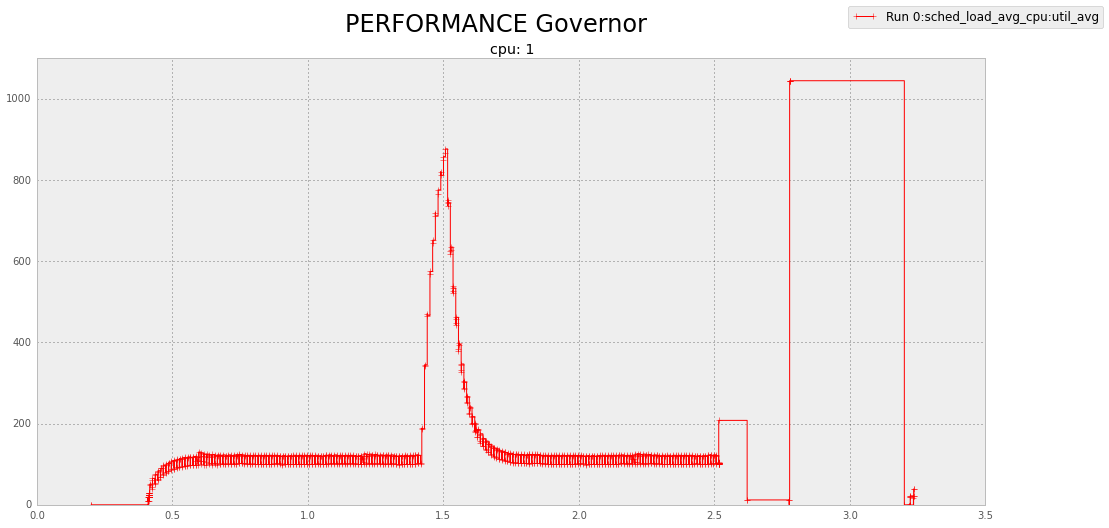

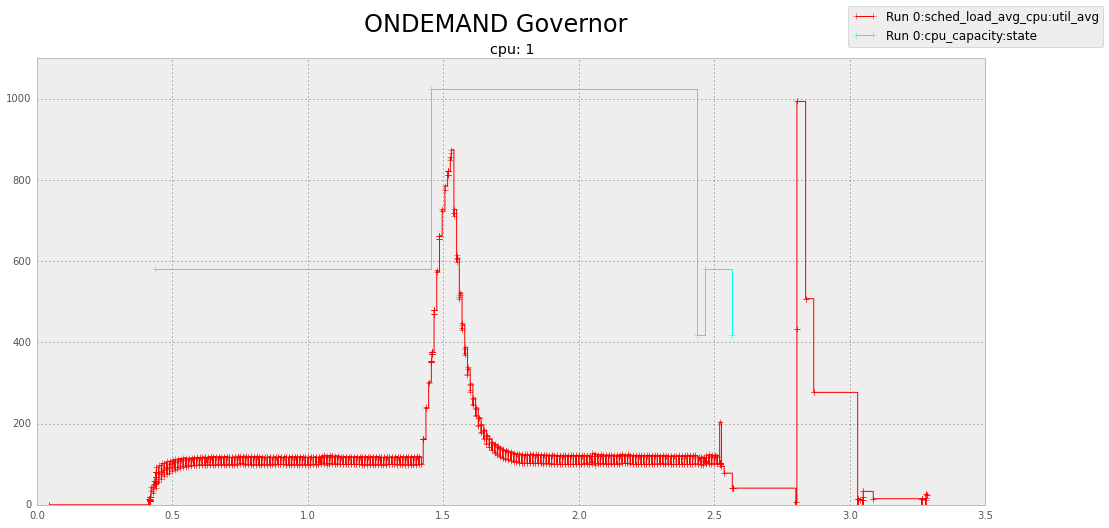

In [12]:
plot(test_case)

## Task with phases: light/heavy/medium

In [13]:
# Define a label for this test case
test_case = 'light-heavy-medium'

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : {
            'phases' : [
                # duration [s]
                # |     period [ms]
                # |     |      duty-cycle [%]
                # |     |      |
                 (1.0,  10,   10),
                 (0.1, 100,   90),
                 (1.0,  10,   50)
            ],
            'cpus': str(target.bl.bigs_online[0])
        }
    },
    run_dir=target.working_directory
);

06:32:19  ERROR   : Assuming taskset is preinstalled
06:32:19  INFO    : Setup new workload smoke
06:32:20  INFO    : Workload duration defined by longest task
06:32:20  INFO    : Default policy: SCHED_OTHER
06:32:20  INFO    : ------------------------
06:32:20  INFO    : task [task1], sched: using default policy
06:32:20  INFO    :  | loops count: 1
06:32:20  INFO    :  | CPUs affinity: 1
06:32:20  INFO    :  + phase_000001: duration 1.000000 [s] (100 loops)
06:32:20  INFO    :  |  period    10000 [us], duty_cycle  10 %
06:32:20  INFO    :  |  run_time   1000 [us], sleep_time   9000 [us]
06:32:20  INFO    :  + phase_000002: duration 0.100000 [s] (1 loops)
06:32:20  INFO    :  |  period   100000 [us], duty_cycle  90 %
06:32:20  INFO    :  |  run_time  90000 [us], sleep_time  10000 [us]
06:32:20  INFO    :  + phase_000003: duration 1.000000 [s] (100 loops)
06:32:20  INFO    :  |  period    10000 [us], duty_cycle  50 %
06:32:20  INFO    :  |  run_time   5000 [us], sleep_time   5000 [us]


In [14]:
# Run this workload in all the configurations
compare(test_case, rtapp)

06:32:20  INFO    : Test case: light-heavy-medium
06:32:20  INFO    :   results folder: /home/derkling/Code/schedtest/results/20151111_183140/light-heavy-medium
06:32:20  INFO    : ------------------------
06:32:20  INFO    : Run workload using performance governor
06:32:25  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:32:28  INFO    : Executor [end]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:32:32  INFO    : ------------------------
06:32:32  INFO    : Run workload using ondemand governor
06:32:49  INFO    : Executor [start]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
06:32:51  INFO    : Executor [end]: /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json


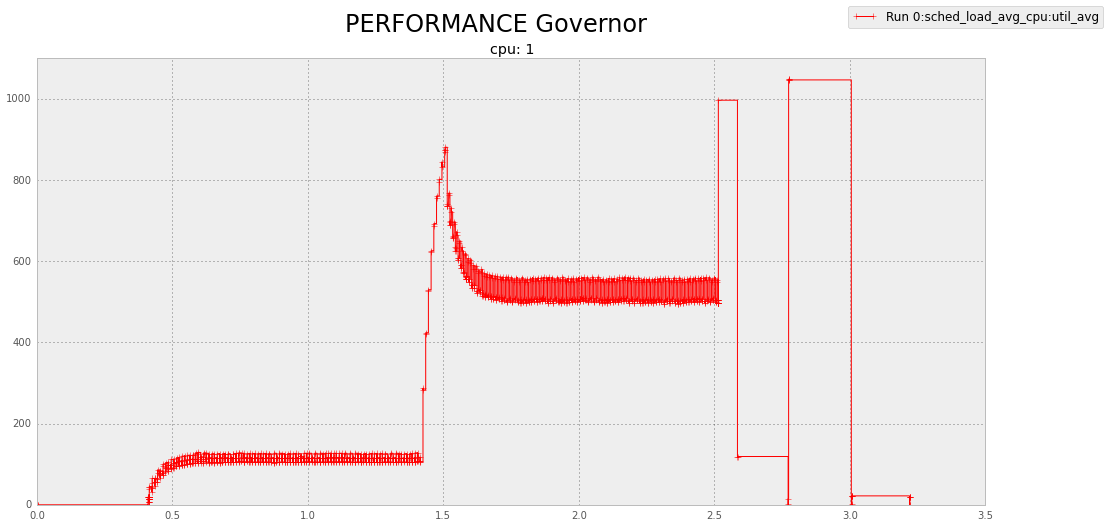

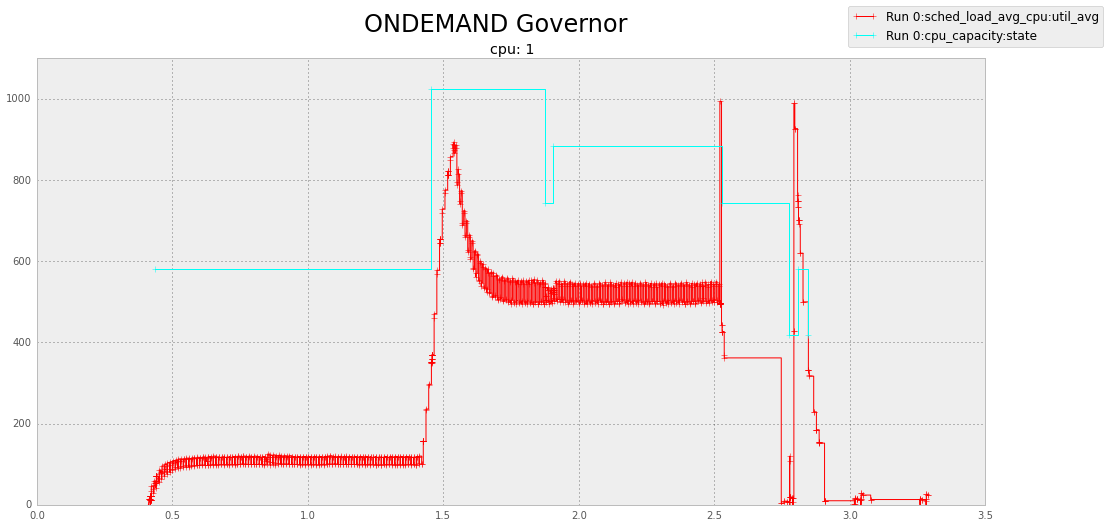

In [15]:
plot(test_case)